In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import re
import nltk
from nltk.tokenize import RegexpTokenizer

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

/Users/alexbolanos/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
start_time = time.time()
full_reviews = pd.read_csv('glassdoor_reviews.csv')
end_time = time.time()
timeMeasured = end_time - start_time
print('Took ' + str(timeMeasured) + ' seconds.')

/Users/alexbolanos/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Took 63.0721399784 seconds.


In [3]:
full_reviews.dtypes

Ticker Symbol                    object
Entity Name                      object
Dataset                           int64
CUSIP                            object
ISIN                             object
Unique ID                         int64
As Of Date                       object
Review Url                       object
Logo                             object
Author Title                     object
Author Location                  object
Author Country                   object
Summary                          object
Description                      object
PROs                             object
CONs                             object
Recommends Value                float64
Recommends Description           object
Outlook Value                   float64
Outlook Description              object
CEO Review Value                float64
CEO Review Description           object
Helpful Count                   float64
Rating: Overall                   int64
Rating: Work/Life Balance       float64


In [4]:
print('Number of unique company IDs: {}'.format(full_reviews.loc[:,'Company Id'].nunique()))
print('Number of Total Reviews: {}'.format(full_reviews.shape[0]))
print('Number of information columns per review: {}'.format(full_reviews.shape[1]))

Number of unique company IDs: 5833
Number of Total Reviews: 2631927
Number of information columns per review: 35


# Preliminary Cleaning of Data

In [5]:
reviews = full_reviews.copy()

In [6]:
reviews.shape

(2631927, 35)

In [7]:
reviews.columns

Index([u'Ticker Symbol', u'Entity Name', u'Dataset', u'CUSIP', u'ISIN',
       u'Unique ID', u'As Of Date', u'Review Url', u'Logo', u'Author Title',
       u'Author Location', u'Author Country', u'Summary', u'Description',
       u'PROs', u'CONs', u'Recommends Value', u'Recommends Description',
       u'Outlook Value', u'Outlook Description', u'CEO Review Value',
       u'CEO Review Description', u'Helpful Count', u'Rating: Overall',
       u'Rating: Work/Life Balance', u'Rating: Culture & Values',
       u'Rating: Career Opportunities', u'Rating: Comp & Benefits',
       u'Rating: Senior Management', u'Company Id', u'Company URL',
       u'Date Added', u'Date Updated', u'Ticker Sector', u'Ticker Industry'],
      dtype='object')

Dataset contains 35 pieces of information for each review. Not all of them are significant for us to keep given our focus. We can drop the columns that are not relevant. We can drop: 
Entity Name, Datset, CUSIP, ISIN, Unique ID, As Of Date, Review Url, Logo, Date Updated. 

In [8]:
reviews1 = reviews.drop(['Entity Name', 'Dataset','CUSIP', 'ISIN', 'Unique ID', 'As Of Date','Review Url',
                       'Logo', 'Date Updated'], axis=1)

In [9]:
print(reviews1.shape)
print(reviews1.columns)

(2631927, 26)
Index([u'Ticker Symbol', u'Author Title', u'Author Location',
       u'Author Country', u'Summary', u'Description', u'PROs', u'CONs',
       u'Recommends Value', u'Recommends Description', u'Outlook Value',
       u'Outlook Description', u'CEO Review Value', u'CEO Review Description',
       u'Helpful Count', u'Rating: Overall', u'Rating: Work/Life Balance',
       u'Rating: Culture & Values', u'Rating: Career Opportunities',
       u'Rating: Comp & Benefits', u'Rating: Senior Management', u'Company Id',
       u'Company URL', u'Date Added', u'Ticker Sector', u'Ticker Industry'],
      dtype='object')


In [10]:
reviews1.loc[:,'Company Id'].value_counts().value_counts()

1       245
2       172
3       169
4       151
6       121
7       107
5       104
10       97
9        93
8        93
11       84
12       78
13       60
18       57
14       54
28       53
20       53
19       52
16       50
15       50
23       41
17       40
21       40
26       38
27       33
25       30
24       29
31       29
47       28
45       26
       ... 
358       1
4456      1
2423      1
2439      1
534       1
526       1
2571      1
522       1
518       1
514       1
506       1
498       1
4592      1
4588      1
490       1
2535      1
478       1
462       1
2507      1
4552      1
450       1
442       1
2487      1
2483      1
434       1
426       1
2459      1
406       1
394       1
2017      1
Name: Company Id, Length: 1277, dtype: int64

In [11]:
reviews1.shape

(2631927, 26)

In [12]:
reviews1.columns

Index([u'Ticker Symbol', u'Author Title', u'Author Location',
       u'Author Country', u'Summary', u'Description', u'PROs', u'CONs',
       u'Recommends Value', u'Recommends Description', u'Outlook Value',
       u'Outlook Description', u'CEO Review Value', u'CEO Review Description',
       u'Helpful Count', u'Rating: Overall', u'Rating: Work/Life Balance',
       u'Rating: Culture & Values', u'Rating: Career Opportunities',
       u'Rating: Comp & Benefits', u'Rating: Senior Management', u'Company Id',
       u'Company URL', u'Date Added', u'Ticker Sector', u'Ticker Industry'],
      dtype='object')

In [13]:
start_time = time.time()

# determine that Author Title should only have 2 parts, and split
reviews1.loc[:, 'title_length'] = reviews1.loc[:,'Author Title'].apply(lambda x: len(x.split(' - ')))

# Only consider reviews of proper format 
reviews1 = reviews1[reviews1['title_length'] == 2]

#'Author Title' of all reviews now 2
reviews1 = reviews1.drop('title_length', axis=1)

# Break up "Author Title" into two columns: "Employee Status" and "Job Title"
reviews1.loc[:,'Employee Status'] = reviews1.loc[:,'Author Title'].apply(lambda x: x.split(' - ')[0])
reviews1.loc[:,'Job Title'] = reviews1.loc[:,'Author Title'].apply(lambda x: x.split(' - ')[1])

# remove 10 reviews have incorrect "Employee Status" 
#("Employee Status" not like "Current Employee", "Former Intern", etc.)
reviews1 = reviews1[reviews1['Employee Status'] != 'module.emp-review.current-'] #remove 4 reviews
reviews1 = reviews1[reviews1['Employee Status'] != 'module.emp-review.former-'] #remove 6 reviews

#add extra columns that states if employee is current or former employee
reviews1.loc[:,'current_or_former'] = reviews1.loc[:,'Employee Status'].apply(lambda x: x.split(' ')[0])

print('Took ' + str(time.time()-start_time) + ' seconds.')

Took 23.3198571205 seconds.


In [14]:
reviews1.head()

,Ticker Symbol,Author Title,Author Location,Author Country,Summary,Description,PROs,CONs,Recommends Value,Recommends Description,...,Rating: Comp & Benefits,Rating: Senior Management,Company Id,Company URL,Date Added,Ticker Sector,Ticker Industry,Employee Status,Job Title,current_or_former
0,vtx:rog,Current Contractor - Anonymous Contractor,NaN,NaN,"""Nice first job""",I have been working at Genentech as a contractor,Enjoy the research challenges faced everyday,"Without a phd, it's impossible for an upward c...",1.0,Recommends,...,NaN,NaN,274,https://www.glassdoor.com/Overview/Working-at-...,2018-09-10 11:09:33.94152+00,Health Care,Pharmaceuticals & Biotechnology,Current Contractor,Anonymous Contractor,Current
1,bcs:falabella,Current Employee - Senior Engineer,Bengaluru (India),IND,"""Best Place to Work""",I have been working at Falabella full-time (Le...,Lots to learnEmployee friendly policiesFree me...,No Cons as of now.,1.0,Recommends,...,5.0,4.0,10976,https://www.glassdoor.com/Overview/Working-at-...,2018-09-10 11:37:46.166988+00,NaN,NaN,Current Employee,Senior Engineer,Current
2,asx:wow,Current Employee - Anonymous Employee,NaN,NaN,"""Overall good place to work""",I have been working at Big W part-time,people are fun and very helpful,the occassional manager who doesn't do anything,NaN,NaN,...,NaN,NaN,473193,https://www.glassdoor.com/Overview/Working-at-...,2018-09-10 11:07:27.618957+00,Consumer Services,Food & Drug Retailers,Current Employee,Anonymous Employee,Current
3,asx:wor,Former Employee - Anonymous Employee,NaN,NaN,"""Safety Engineer""",I worked at WorleyParsons full-time,Access to top notch resources that set you up ...,"I did not experience any 'remarkable"" cons",1.0,Recommends,...,4.0,4.0,35193,https://www.glassdoor.com/Overview/Working-at-...,2018-09-10 11:07:23.474903+00,NaN,NaN,Former Employee,Anonymous Employee,Former
4,nyse:xom,Former Employee - I T Analyst,"Houston, TX",USA,"""I.T. Analyst - Global Services Company""",I worked at ExxonMobil full-time (More than 10...,"Great benefits, smart co-workers, state of the...","Forced ranking, slow to adopt new technology, ...",1.0,Recommends,...,5.0,4.0,237,https://www.glassdoor.com/Overview/Working-at-...,2018-09-10 07:53:45.26833+00,Oil & Gas,Oil & Gas Producers,Former Employee,I T Analyst,Former


In [15]:
reviews1.loc[:,'company_name'] = reviews1.loc[:,'Company URL'].apply(lambda x: " ".join(x.split('-')[2:-1]))

In [16]:
reviews1.columns

Index([u'Ticker Symbol', u'Author Title', u'Author Location',
       u'Author Country', u'Summary', u'Description', u'PROs', u'CONs',
       u'Recommends Value', u'Recommends Description', u'Outlook Value',
       u'Outlook Description', u'CEO Review Value', u'CEO Review Description',
       u'Helpful Count', u'Rating: Overall', u'Rating: Work/Life Balance',
       u'Rating: Culture & Values', u'Rating: Career Opportunities',
       u'Rating: Comp & Benefits', u'Rating: Senior Management', u'Company Id',
       u'Company URL', u'Date Added', u'Ticker Sector', u'Ticker Industry',
       u'Employee Status', u'Job Title', u'current_or_former',
       u'company_name'],
      dtype='object')

In [17]:
reviews1['company_name'].value_counts()

IBM                               38666
Walmart                           36138
Accenture                         34731
Target                            28070
Infosys                           27596
Amazon                            25006
Cognizant Technology Solutions    21784
Microsoft                         20081
Wells Fargo                       19997
Bank of America                   19654
Oracle                            19388
McDonald s                        19183
AT and T                          18696
The Home Depot                    17991
Best Buy                          16793
Starbucks                         16736
Macy s                            15970
Lowe s                            15937
Wipro                             15506
Cisco Systems                     15131
J P Morgan                        15076
CVS Health                        13709
Apple                             13045
Walgreens                         12813
Intel Corporation                 11723


# Data Characteristics 

In [18]:
public = len(reviews1['Ticker Symbol'].unique())  # Number of unique public companies
print('Number of unique public companies: ' + str(public))
totalCompanies = len(full_reviews['Dataset'].unique())         # Dataset = unique number identifier
print('Total number of unique companies: ' + str(totalCompanies))
#print len(data['Company Id'].unique())       # Number of unique companies. 
private = totalCompanies - public
print('Number of unique private companies: ' + str(private))

sector = len(reviews1['Ticker Sector'].unique())      # 11 unique sectors
print('Number of unique sectors: ' + str(sector))
industry =  len(reviews1['Ticker Industry'].unique()) # 40 unique industries
print('Number of unique industries: ' + str(industry))
totalReviews = len(reviews1)   # Total length of company reviews dataset
print('Total number of reviews: ' + str(totalReviews))

Number of unique public companies: 4937
Total number of unique companies: 5833
Number of unique private companies: 896
Number of unique sectors: 11
Number of unique industries: 40
Total number of reviews: 2615681


In [19]:
avgReviews = (1.0*totalReviews)/(totalCompanies)
print('Average number of reviews per company: ' + str(avgReviews))

Average number of reviews per company: 448.428081605


In [20]:
sector = reviews1['Ticker Sector'].unique()
print('11 Unique Sectors:')
print(sector)
print('')

print('40 Unique Industries:')
industry = reviews1['Ticker Industry'].unique()
print(industry)

11 Unique Sectors:
['Health Care' nan 'Consumer Services' 'Oil & Gas' 'Industrials'
 'Financials' 'Technology' 'Consumer Goods' 'Telecommunications'
 'Utilities' 'Basic Materials']

40 Unique Industries:
['Pharmaceuticals & Biotechnology' nan 'Food & Drug Retailers'
 'Oil & Gas Producers' 'Industrial Engineering' 'General Industrials'
 'General Financial' 'Software & Computer Services'
 'Industrial Transportation' 'Financial Services'
 'Construction & Materials' 'Banks' 'Aerospace & Defense' 'Food Producers'
 'General Retailers' 'Health Care Equipment & Services'
 'Technology Hardware & Equipment' 'Life Insurance' 'Support Services'
 'Media' 'Household Goods' 'Mobile Telecommunications'
 'Oil Equipment, Services & Distribution' 'Alternative Energy'
 'Travel & Leisure' 'Leisure Goods' 'Personal Goods' 'Automobiles & Parts'
 'Tobacco' 'Fixed Line Telecommunications' 'Electricity'
 'Nonlife Insurance' 'Industrial Metals' 'Chemicals'
 'Electronic & Electrical Equipment' 'Beverages' 'Forest

Cut reviews to only focus on companies based in U.S.A. 

In [21]:
reviewsUSA = reviews1[reviews1['Author Country']=='USA']
print('Numbers of Reviews left by USA-based employees: {}'.format(len(reviewsUSA)))
reviewsCurrent = reviewsUSA[reviewsUSA['current_or_former']=='Current']
print('Number of Reviews left by Current employees: {}'.format(len(reviewsCurrent)))
reviewsFormer = reviewsUSA[reviewsUSA['current_or_former']=='Former']
print('Number of Reviews left by Former employees: {}'.format(len(reviewsFormer)))


Numbers of Reviews left by USA-based employees: 1126866
Number of Reviews left by Current employees: 603689
Number of Reviews left by Former employees: 523177


In [22]:
public = len(reviewsUSA['Ticker Symbol'].unique())  # Number of unique public companies
print('Number of unique public companies: ' + str(public))
totalCompanies = len(reviewsUSA['Company Id'].unique())         # Dataset = unique number identifier
print('Total number of unique companies: ' + str(totalCompanies))
#print len(data['Company Id'].unique())       # Number of unique companies. 
private = totalCompanies - public
print('Number of unique private companies: ' + str(private))

sector = len(reviewsUSA['Ticker Sector'].unique())      # 11 unique sectors
print('Number of unique sectors: ' + str(sector))
industry =  len(reviewsUSA['Ticker Industry'].unique()) # 40 unique industries
print('Number of unique industries: ' + str(industry))
totalReviews = len(reviewsUSA)   # Total length of company reviews dataset
print('Total number of reviews: ' + str(totalReviews))

Number of unique public companies: 4492
Total number of unique companies: 5304
Number of unique private companies: 812
Number of unique sectors: 11
Number of unique industries: 40
Total number of reviews: 1126866


In [23]:
reviewsUSA.head()

,Ticker Symbol,Author Title,Author Location,Author Country,Summary,Description,PROs,CONs,Recommends Value,Recommends Description,...,Rating: Senior Management,Company Id,Company URL,Date Added,Ticker Sector,Ticker Industry,Employee Status,Job Title,current_or_former,company_name
4,nyse:xom,Former Employee - I T Analyst,"Houston, TX",USA,"""I.T. Analyst - Global Services Company""",I worked at ExxonMobil full-time (More than 10...,"Great benefits, smart co-workers, state of the...","Forced ranking, slow to adopt new technology, ...",1.0,Recommends,...,4.0,237,https://www.glassdoor.com/Overview/Working-at-...,2018-09-10 07:53:45.26833+00,Oil & Gas,Oil & Gas Producers,Former Employee,I T Analyst,Former,ExxonMobil
5,nyse:cat,Current Employee - Welder/Fabricator,"Aurora, IL",USA,"""Decent job with decent pay.""",I have been working at Caterpillar full-time (...,Steady 40 hours a week. Union job.,Company is more worried about the all might do...,1.0,Recommends,...,3.0,137,https://www.glassdoor.com/Overview/Working-at-...,2018-09-10 05:22:30.202947+00,Industrials,Industrial Engineering,Current Employee,Welder/Fabricator,Current,Caterpillar
6,nyse:wrk,Current Employee - Quality,"Mebane, NC",USA,"""Quality""",I have been working at WestRock full-time (Mor...,Excellent health care and stock. 401k needs im...,No raise or pay adjustment in 2 years. Nothing...,-1.0,Doesn't Recommend,...,1.0,1033056,https://www.glassdoor.com/Overview/Working-at-...,2018-09-10 07:52:04.797509+00,Industrials,General Industrials,Current Employee,Quality,Current,WestRock
7,nyse:cxw,Former Employee - Administrative Clerk,"Tutwiler, MS",USA,"""Not a good place to working""",I worked at Corrections Corporation of America...,"Definite raises, guaranteed pay",No unity. Management is undermining and sneaky.,-1.0,Doesn't Recommend,...,1.0,6826,https://www.glassdoor.com/Overview/Working-at-...,2018-09-10 05:37:42.917784+00,Financials,General Financial,Former Employee,Administrative Clerk,Former,Corrections Corporation of America
10,sto:secu-b,Current Employee - Security Officer,"Hillsboro, OR",USA,"""I enjoy the people here""",I have been working at Securitas Security Serv...,"It is a very large, stable company that has be...",I've been there a month now and have no cons.,1.0,Recommends,...,5.0,16559,https://www.glassdoor.com/Overview/Working-at-...,2018-09-10 11:03:30.511047+00,NaN,NaN,Current Employee,Security Officer,Current,Securitas Security Services USA


In [24]:
reviewsUSA.loc[:,'Author_State'] = reviewsUSA.loc[:,'Author Location'].apply(lambda x: x.split(', ')[-1])

/Users/alexbolanos/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/alexbolanos/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [25]:
#reviewsUSA['Author_State'].value_counts()

In [26]:
#reviewsUSA.head()

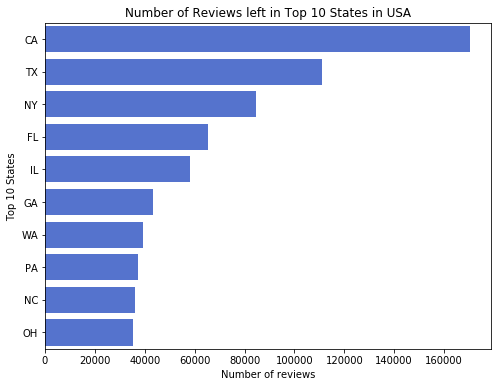

In [27]:
plt.rcParams['figure.figsize'] = 8,6
g2  = sns.barplot(reviewsUSA['Author_State'].value_counts().values[:10], 
                  reviewsUSA['Author_State'].value_counts().index[:10], color='royalblue') #top ten states
#dummy = g2.set_xticklabels(g2.get_xticklabels(), rotation=90)
plt.xlabel('Number of reviews')
plt.ylabel('Top 10 States')
plt.title('Number of Reviews left in Top 10 States in USA')
plt.show()


We can see that California, Texas, and New York take the lead with the most number of reviews left in regards of the companies they host. Will be interesting to get a sense for the major hubs for employment, and how sentiment is represented in each one. 

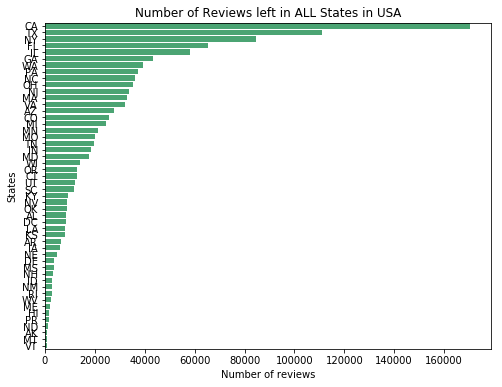

In [28]:
plt.rcParams['figure.figsize'] = 8,6
g2  = sns.barplot(reviewsUSA['Author_State'].value_counts().values[:50], 
                  reviewsUSA['Author_State'].value_counts().index[:50], color='mediumseagreen') #top ten states
#dummy = g2.set_xticklabels(g2.get_xticklabels(), rotation=90)
plt.xlabel('Number of reviews')
plt.ylabel('States')
plt.title('Number of Reviews left in ALL States in USA')
plt.show()

In [29]:
reviewsUSA['Author_State'].value_counts().index[:56]

Index([u'CA', u'TX', u'NY', u'FL', u'IL', u'GA', u'WA', u'PA', u'NC', u'OH',
       u'NJ', u'MA', u'VA', u'AZ', u'CO', u'MI', u'MN', u'MO', u'TN', u'IN',
       u'MD', u'WI', u'OR', u'CT', u'UT', u'SC', u'KY', u'NV', u'OK', u'AL',
       u'DC', u'LA', u'KS', u'AR', u'IA', u'NE', u'DE', u'MS', u'NH', u'ID',
       u'NM', u'RI', u'WV', u'ME', u'HI', u'PR', u'ND', u'AK', u'MT', u'VT',
       u'SD', u'WY', u'GU', u'VI', u'AS', u'MP'],
      dtype='object')

There are 56 state names included in dataset because other US territories are being included in Dataset.
These include: DC, PR, GU, VI, AS, MP. While we can keep DC since it contains a significant number of company reviews, the others should probably be ignored.

# HELP WITH HEAT MAP OF EMPLOYEE REVIEWS / STATE

# A look at Sectors and Industries within Reviews

Distribution of Sectors within Jobs Reviewed

In [30]:
ddSector = reviewsUSA.groupby('Ticker Sector')['company_name'].count().sort_values(ascending = False)
pd.DataFrame({'count':ddSector})

,count
Ticker Sector,
Consumer Services,386808
Industrials,157943
Financials,141556
Technology,141071
Consumer Goods,64983
Health Care,64958
Telecommunications,41076
Oil & Gas,18289
Basic Materials,10202


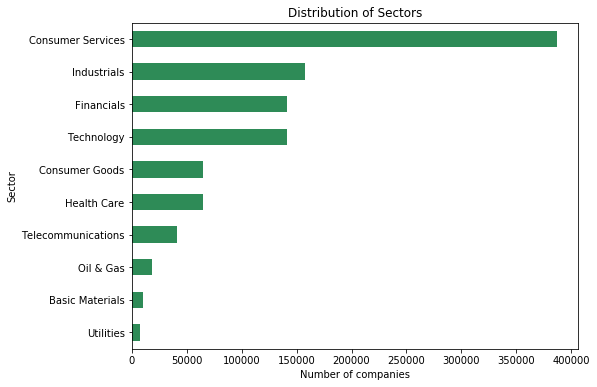

In [31]:
reviewsUSA.groupby('Ticker Sector')['company_name'].count().sort_values().plot.barh(color = 'seagreen')
plt.ylabel('Sector')
plt.xlabel('Number of companies')
plt.title('Distribution of Sectors')
plt.show()

Distribution of Industries within Jobs Reviewed in USA

In [32]:
ddIndustry = reviewsUSA.groupby('Ticker Industry')['company_name'].count().sort_values(ascending = False)
pd.DataFrame({'count':ddIndustry})

,count
Ticker Industry,
General Retailers,220122
Travel & Leisure,96581
Software & Computer Services,86872
Banks,69250
Support Services,67383
Technology Hardware & Equipment,51235
Health Care Equipment & Services,44764
Media,39182
Financial Services,36219


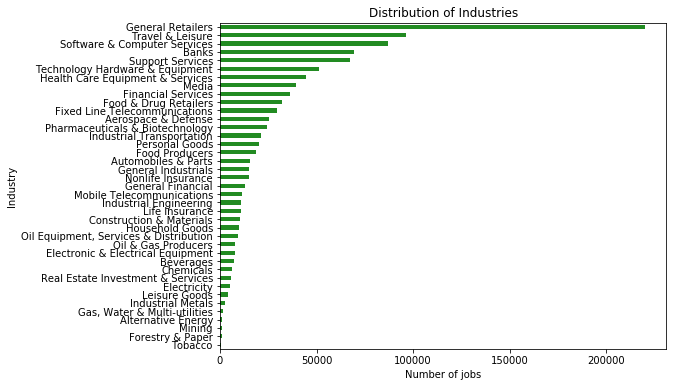

In [33]:
reviewsUSA.groupby('Ticker Industry')['company_name'].count().sort_values().plot.barh(color = 'forestgreen')
plt.ylabel('Industry')
plt.xlabel('Number of jobs')
plt.title('Distribution of Industries')
plt.show()

Top 20 Most Reviewed Companies

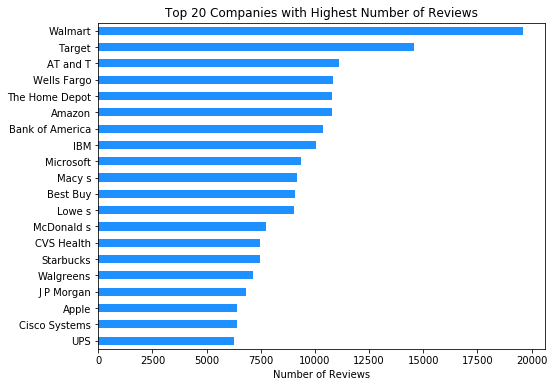

In [34]:
reviewsUSA['company_name'].value_counts().head(20)[::-1].plot.barh(color='dodgerblue')
plt.xlabel('Number of Reviews')
plt.title('Top 20 Companies with Highest Number of Reviews')
plt.show()

# High Level Look at Ratings

(5,)


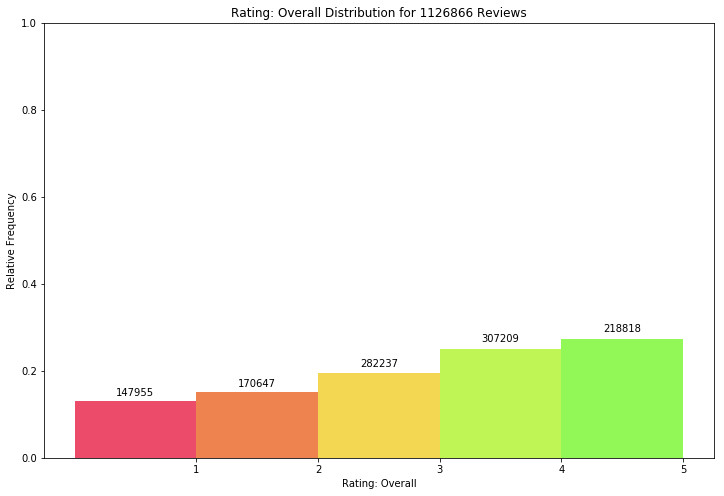

In [35]:
N_star_categories = 5
colors = np.array(['#E50029', '#E94E04', '#EEC708', '#A5F30D', '#62F610']) # 1, 2, 3, 4, and 5 stars respectively
stars_labels = np.array([x_stars+1 for x_stars in range(N_star_categories)])
star_category_dist_fig = plt.figure(figsize=(12,8))
bar_plot_indices = np.arange(N_star_categories)
print(np.shape(reviewsUSA['Rating: Overall'].value_counts(ascending=True)))
star_category_absolute_frequencies = reviewsUSA['Rating: Overall'].value_counts(ascending=True)
star_category_relative_frequencies = np.array(star_category_absolute_frequencies)/float(sum(star_category_absolute_frequencies))

rects = plt.bar(bar_plot_indices, star_category_relative_frequencies, width=1, color=colors, alpha=.7)
for (idx, rect) in enumerate(rects):
        plt.gca().text(rect.get_x()+rect.get_width()/2., 1.05*rect.get_height(), '%d'%int(star_category_absolute_frequencies[idx+1]),
                ha='center', va='bottom')


plt.xticks(bar_plot_indices+.5, stars_labels)
plt.xlabel('Rating: Overall')
plt.ylabel('Relative Frequency')
plt.ylim([0,1])
plt.title('Rating: Overall Distribution for {0} Reviews'.format(len(reviewsUSA)))

plt.show()

Rating: Overall

We can see the general distribution among ratings that is skewed to the higher ratings of 4 and 5. 

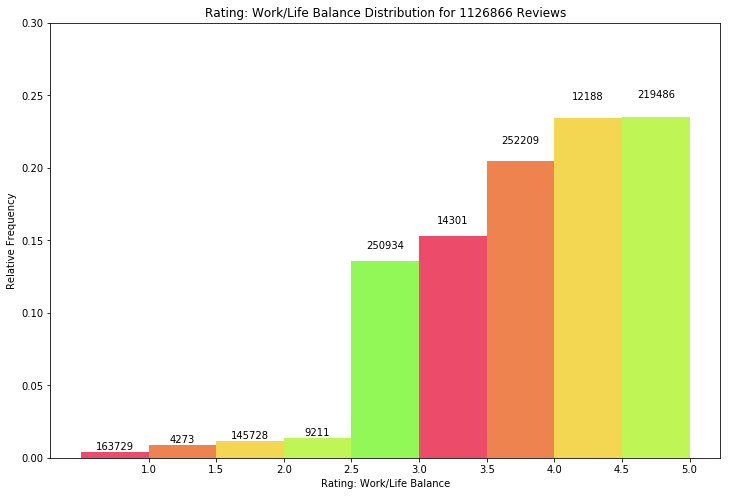

In [36]:
N_star_categories = 9
colors = np.array(['#E50029', '#E94E04', '#EEC708', '#A5F30D', '#62F610', '#E50029', '#E94E04', '#EEC708', '#A5F30D']) # 1, 2, 3, 4, and 5 stars respectively
stars_labels = np.array([(x_stars+2)/2.0 for x_stars in range(N_star_categories)])
star_category_dist_fig = plt.figure(figsize=(12,8))
bar_plot_indices = np.arange(N_star_categories)

star_category_absolute_frequencies = reviewsUSA['Rating: Work/Life Balance'].value_counts(ascending=True)
star_category_relative_frequencies = np.array(star_category_absolute_frequencies)/float(sum(star_category_absolute_frequencies))

rects = plt.bar(bar_plot_indices, star_category_relative_frequencies, width=1, color=colors, alpha=.7)
for (idx, rect) in enumerate(rects):
    plt.gca().text(rect.get_x()+rect.get_width()/2., 1.05*rect.get_height(), '%d'%int(star_category_absolute_frequencies[(idx+2)/2.0]),
                ha='center', va='bottom')


plt.xticks(bar_plot_indices+.5, stars_labels)
plt.xlabel('Rating: Work/Life Balance')
plt.ylabel('Relative Frequency')
plt.ylim([0,0.3])
plt.title('Rating: Work/Life Balance Distribution for {0} Reviews'.format(len(reviewsUSA)))

plt.show()

Rating: Work/Life Balance

We can see the trend of better work life balance being a point of focus for companies. Many individuals rated their companies as providing them with positive balance. 

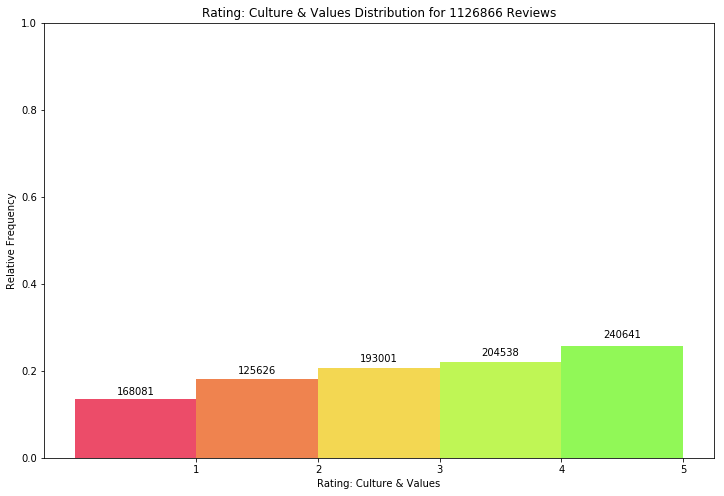

In [37]:
N_star_categories = 5
colors = np.array(['#E50029', '#E94E04', '#EEC708', '#A5F30D', '#62F610']) # 1, 2, 3, 4, and 5 stars respectively
stars_labels = np.array([x_stars+1 for x_stars in range(N_star_categories)])
star_category_dist_fig = plt.figure(figsize=(12,8))
bar_plot_indices = np.arange(N_star_categories)
star_category_absolute_frequencies = reviewsUSA['Rating: Culture & Values'].value_counts(ascending=True)
star_category_relative_frequencies = np.array(star_category_absolute_frequencies)/float(sum(star_category_absolute_frequencies))

rects = plt.bar(bar_plot_indices, star_category_relative_frequencies, width=1, color=colors, alpha=.7)
for (idx, rect) in enumerate(rects):
        plt.gca().text(rect.get_x()+rect.get_width()/2., 1.05*rect.get_height(), '%d'%int(star_category_absolute_frequencies[idx+1]),
                ha='center', va='bottom')


plt.xticks(bar_plot_indices+.5, stars_labels)
plt.xlabel('Rating: Culture & Values')
plt.ylabel('Relative Frequency')
plt.ylim([0,1])
plt.title('Rating: Culture & Values Distribution for {0} Reviews'.format(len(reviewsUSA)))

plt.show()

Rating: Culture & Values

Similar to Rating: Overall. Skewed more positively. Will this be an indicator for Overall satisfaction?

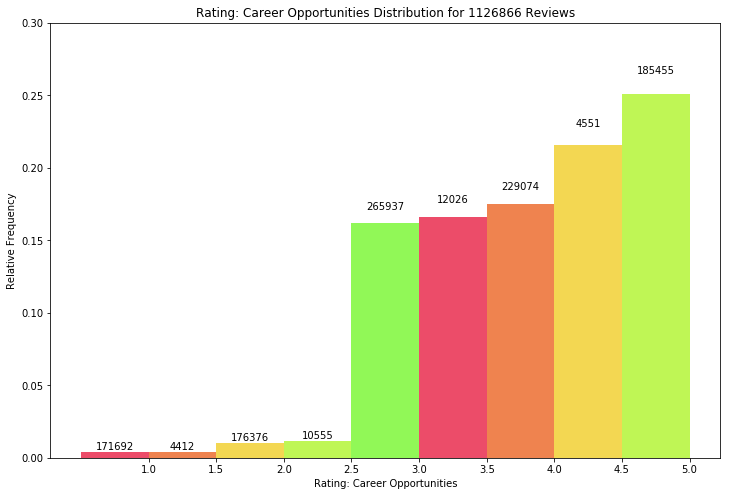

In [38]:
N_star_categories = 9
colors = np.array(['#E50029', '#E94E04', '#EEC708', '#A5F30D', '#62F610', '#E50029', '#E94E04', '#EEC708', '#A5F30D']) # 1, 2, 3, 4, and 5 stars respectively
stars_labels = np.array([(x_stars+2)/2.0 for x_stars in range(N_star_categories)])
star_category_dist_fig = plt.figure(figsize=(12,8))
bar_plot_indices = np.arange(N_star_categories)

star_category_absolute_frequencies = reviewsUSA['Rating: Career Opportunities'].value_counts(ascending=True)
star_category_relative_frequencies = np.array(star_category_absolute_frequencies)/float(sum(star_category_absolute_frequencies))

rects = plt.bar(bar_plot_indices, star_category_relative_frequencies, width=1, color=colors, alpha=.7)
for (idx, rect) in enumerate(rects):
    plt.gca().text(rect.get_x()+rect.get_width()/2., 1.05*rect.get_height(), '%d'%int(star_category_absolute_frequencies[(idx+2)/2.0]),
                ha='center', va='bottom')


plt.xticks(bar_plot_indices+.5, stars_labels)
plt.xlabel('Rating: Career Opportunities')
plt.ylabel('Relative Frequency')
plt.ylim([0,0.3])
plt.title('Rating: Career Opportunities Distribution for {0} Reviews'.format(len(reviewsUSA)))

plt.show()

Rating: Career Opportunities

Most companies offer employees with opportunities to grow professionally and pursue career paths within the same company. This is a common trend for stability that is an attractive feature for employees, and something companies are focusing on more and more.

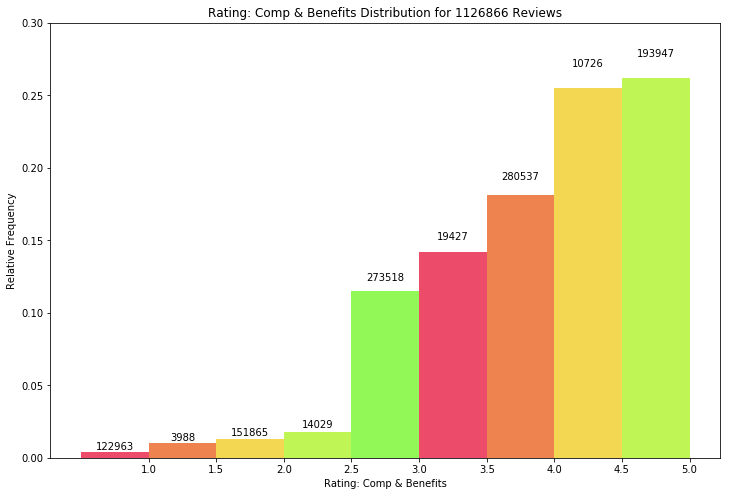

In [39]:
N_star_categories = 9
colors = np.array(['#E50029', '#E94E04', '#EEC708', '#A5F30D', '#62F610', '#E50029', '#E94E04', '#EEC708', '#A5F30D']) # 1, 2, 3, 4, and 5 stars respectively
stars_labels = np.array([(x_stars+2)/2.0 for x_stars in range(N_star_categories)])
star_category_dist_fig = plt.figure(figsize=(12,8))
bar_plot_indices = np.arange(N_star_categories)

star_category_absolute_frequencies = reviewsUSA['Rating: Comp & Benefits'].value_counts(ascending=True)
star_category_relative_frequencies = np.array(star_category_absolute_frequencies)/float(sum(star_category_absolute_frequencies))

rects = plt.bar(bar_plot_indices, star_category_relative_frequencies, width=1, color=colors, alpha=.7)
for (idx, rect) in enumerate(rects):
    plt.gca().text(rect.get_x()+rect.get_width()/2., 1.05*rect.get_height(), '%d'%int(star_category_absolute_frequencies[(idx+2)/2.0]),
                ha='center', va='bottom')


plt.xticks(bar_plot_indices+.5, stars_labels)
plt.xlabel('Rating: Comp & Benefits')
plt.ylabel('Relative Frequency')
plt.ylim([0,0.3])
plt.title('Rating: Comp & Benefits Distribution for {0} Reviews'.format(len(reviewsUSA)))

plt.show()

Rating: Compensation & Benefits

This shows us how companies generally are aware of what employees deserve to compete with other companies for talent, as well as retain them within the company. Would be interesting to look deeper into if we had salary data for each company, positions, and locations.

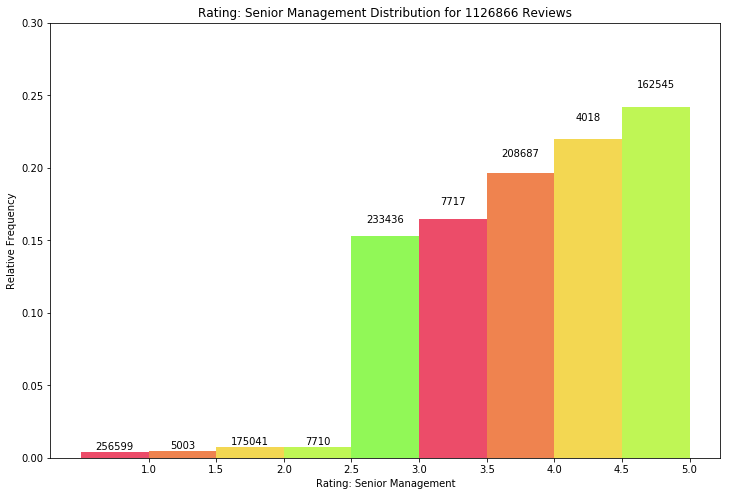

In [40]:
N_star_categories = 9
colors = np.array(['#E50029', '#E94E04', '#EEC708', '#A5F30D', '#62F610', '#E50029', '#E94E04', '#EEC708', '#A5F30D']) # 1, 2, 3, 4, and 5 stars respectively
stars_labels = np.array([(x_stars+2)/2.0 for x_stars in range(N_star_categories)])
star_category_dist_fig = plt.figure(figsize=(12,8))
bar_plot_indices = np.arange(N_star_categories)

star_category_absolute_frequencies = reviewsUSA['Rating: Senior Management'].value_counts(ascending=True)
star_category_relative_frequencies = np.array(star_category_absolute_frequencies)/float(sum(star_category_absolute_frequencies))

rects = plt.bar(bar_plot_indices, star_category_relative_frequencies, width=1, color=colors, alpha=.7)
for (idx, rect) in enumerate(rects):
    plt.gca().text(rect.get_x()+rect.get_width()/2., 1.05*rect.get_height(), '%d'%int(star_category_absolute_frequencies[(idx+2)/2.0]),
                ha='center', va='bottom')


plt.xticks(bar_plot_indices+.5, stars_labels)
plt.xlabel('Rating: Senior Management')
plt.ylabel('Relative Frequency')
plt.ylim([0,0.3])
plt.title('Rating: Senior Management Distribution for {0} Reviews'.format(len(reviewsUSA)))

plt.show()

Rating: Senior Management

Will this be a key indicator for overall satisfaction? we can see the focus of companies on providing great senior management by looking at these numbers. Clearly some still struggle with this. Is there a correlation between Senior Management and Overall Rating?

In [41]:
ratings = reviewsUSA[['Rating: Overall', 'Rating: Work/Life Balance', 'Rating: Culture & Values',
                     'Rating: Career Opportunities','Rating: Comp & Benefits','Rating: Senior Management']].copy()

In [42]:
ratings.describe()

,Rating: Overall,Rating: Work/Life Balance,Rating: Culture & Values,Rating: Career Opportunities,Rating: Comp & Benefits,Rating: Senior Management
count,1.126866e+06,1.072059e+06,931887.000000,1.060078e+06,1.071000e+06,1.060756e+06
mean,3.246957e+00,3.216791e+00,3.240407,3.076568e+00,3.264655e+00,2.852995e+00
std,1.290346e+00,1.339422e+00,1.432092,1.322341e+00,1.247406e+00,1.394080e+00
min,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.000000e+00,2.000000e+00,2.000000,2.000000e+00,2.000000e+00,2.000000e+00
50%,3.000000e+00,3.000000e+00,3.000000,3.000000e+00,3.000000e+00,3.000000e+00
75%,4.000000e+00,4.000000e+00,5.000000,4.000000e+00,4.000000e+00,4.000000e+00
max,5.000000e+00,5.000000e+00,5.000000,5.000000e+00,5.000000e+00,5.000000e+00


In [43]:
ratings.corr()

,Rating: Overall,Rating: Work/Life Balance,Rating: Culture & Values,Rating: Career Opportunities,Rating: Comp & Benefits,Rating: Senior Management
Rating: Overall,1.000000,0.629558,0.783673,0.743182,0.605362,0.772032
Rating: Work/Life Balance,0.629558,1.000000,0.610971,0.501290,0.453966,0.598788
Rating: Culture & Values,0.783673,0.610971,1.000000,0.666761,0.530003,0.758469
Rating: Career Opportunities,0.743182,0.501290,0.666761,1.000000,0.583417,0.676393
Rating: Comp & Benefits,0.605362,0.453966,0.530003,0.583417,1.000000,0.517272
Rating: Senior Management,0.772032,0.598788,0.758469,0.676393,0.517272,1.000000


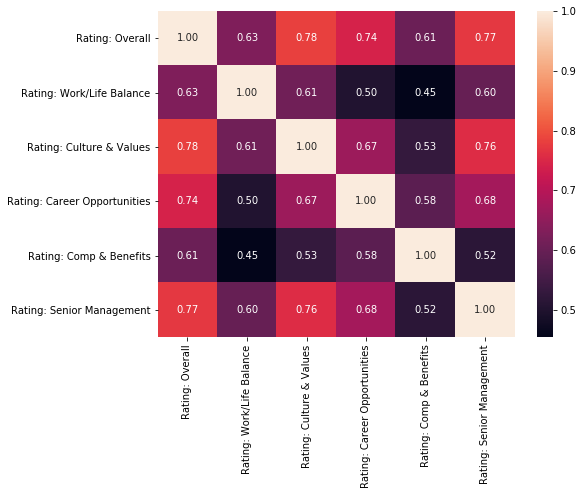

In [44]:
sns.heatmap(ratings.corr(), annot=True ,fmt=".2f")
plt.show()

In [61]:
for i in ratings.columns:
    print(i)
    #print(ratings[i]) -- rating[i] is the rating that each company got in that column category
    print('Mean value: {}'.format(ratings[i].mean()))
    print('Median value: {}'.format(ratings[i].median()))
    print('')

Rating: Overall
Mean value: 3.24695749095
Median value: 3.0

Rating: Work/Life Balance
Mean value: 3.21679077364
Median value: 3.0

Rating: Culture & Values
Mean value: 3.24040683044
Median value: 3.0

Rating: Career Opportunities
Mean value: 3.07656795066
Median value: 3.0

Rating: Comp & Benefits
Mean value: 3.26465546218
Median value: 3.0

Rating: Senior Management
Mean value: 2.85299541082
Median value: 3.0



In [46]:
reviewsUSA.shape

(1126866, 31)

In [47]:
reviewsUSA.to_csv('reviewsUSA.csv')

In [55]:
reviewsCurrent = reviewsUSA[reviewsUSA['current_or_former']=='Current']
reviewsFormer = reviewsUSA[reviewsUSA['current_or_former']=='Former']

In [58]:
reviewsFormer.to_csv('reviewsFormer_all.csv')

In [59]:
reviewsCurrent.to_csv('reviewsCurrent_all.csv')

In [74]:
reviewsUSA['Rating: Overall'][0:5]

4     4
5     3
6     2
7     2
10    5
Name: Rating: Overall, dtype: int64

In [50]:
from wordcloud import WordCloud
# utilizing nltk stopwords to determine if input is english or not

import string
from multiprocessing import Pool, cpu_count

from string import punctuation

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

import nltk
#from gensim import corpora, models
from nltk.corpus import stopwords

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.lda import LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import seaborn as sns

/Users/alexbolanos/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [105]:
reviewsClean1 = reviewsUSA.copy()

In [78]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

In [107]:
reviewsClean1.shape

(1126866, 31)

In [108]:
prosClean = reviewsClean1[['company_name','Recommends Value', 'Outlook Value',
                           'CEO Review Value','Job Title','current_or_former','PROs',]]
consClean = reviewsClean1[['company_name','Recommends Value', 'Outlook Value',
                           'CEO Review Value','Job Title','current_or_former','CONs']]


In [109]:
np.sum(reviewsClean1['PROs'].isnull())


0

In [112]:
np.sum(consClean['CONs'].isnull())

0

In [111]:
consClean.dropna(subset=['CONs'], inplace=True)


/Users/alexbolanos/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [98]:
np.sum(consClean['CONs'].isnull())

0

In [114]:
display(prosClean)

,company_name,Recommends Value,Outlook Value,CEO Review Value,Job Title,current_or_former,PROs
4,ExxonMobil,1.0,1.0,1.0,I T Analyst,Former,"Great benefits, smart co-workers, state of the..."
5,Caterpillar,1.0,0.0,-1.0,Welder/Fabricator,Current,Steady 40 hours a week. Union job.
6,WestRock,-1.0,-1.0,-1.0,Quality,Current,Excellent health care and stock. 401k needs im...
7,Corrections Corporation of America,-1.0,0.0,0.0,Administrative Clerk,Former,"Definite raises, guaranteed pay"
10,Securitas Security Services USA,1.0,1.0,1.0,Security Officer,Current,"It is a very large, stable company that has be..."
11,Goldman Sachs,NaN,NaN,NaN,Anonymous Employee,Former,Lots of learningLots of opportunities
13,Sherwin Williams,1.0,1.0,1.0,Part Time Sales Associate,Former,"Flexible schedule, plenty of advancement oppor..."
15,Lockheed Martin,1.0,1.0,1.0,Software Engineering Intern,Former,- You can work on some really cool stuff if yo...
16,Ahold Delhaize,NaN,NaN,NaN,Accounts Payable Intern,Former,Good co-workersCafe on siteSecure building
18,Humana,1.0,1.0,1.0,Financial Analytics Professional,Current,"Great 401k, vacation time, and flexibility wit..."


In [113]:
#%run sentiment_algos.py
import sentiment_algos as senti

In [130]:
shortPros = prosClean[0:100]
shortCons = consClean[0:100]

In [131]:
start_time = time.time()

# Data Cleaning
for index,row in shortPros.iterrows():
    print index
    #     Removing punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(row['PROs'])
    row['PROs'] = ' '.join(tokens)
#     print(row['answer'])
#   stemming the words
stemmer = SnowballStemmer(language="english", ignore_stopwords = True)
words = stopwords.words('english')
shortPros['cleaned_PROs'] = shortPros['PROs'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ",x).split() if i not in words]).lower())

end_time = time.time()
timeMeasured = end_time - start_time
print('Took ' + str(timeMeasured) + ' seconds.')

display(shortPros)

4
5
6
7
10
11
13
15
16
18
19
20
23
24
30
33
35
43
46
56
59
60
61
63
65
66
67
68
70
71
74
77
78
81
82
83
84
86
87
88
89
95
96
98
102
103
105
106
108
109
111
113
114
115
116
118
121
123
124
126
127
132
133
137
139
141
144
145
147
149
150
151
154
155
156
158
161
163
167
169
170
171
173
180
183
185
186
192
193
194
197
198
199
202
205
207
208
214
218
219
Took 0.235075950623 seconds.


/Users/alexbolanos/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,company_name,Recommends Value,Outlook Value,CEO Review Value,Job Title,current_or_former,PROs,cleaned_PROs
4,ExxonMobil,1.0,1.0,1.0,I T Analyst,Former,"Great benefits, smart co-workers, state of the...",great benefit smart co worker state art facil
5,Caterpillar,1.0,0.0,-1.0,Welder/Fabricator,Current,Steady 40 hours a week. Union job.,steadi hour week union job
6,WestRock,-1.0,-1.0,-1.0,Quality,Current,Excellent health care and stock. 401k needs im...,excel health care stock k need improv
7,Corrections Corporation of America,-1.0,0.0,0.0,Administrative Clerk,Former,"Definite raises, guaranteed pay",definit rais guarante pay
10,Securitas Security Services USA,1.0,1.0,1.0,Security Officer,Current,"It is a very large, stable company that has be...",it larg stabl compani around long time very pr...
11,Goldman Sachs,NaN,NaN,NaN,Anonymous Employee,Former,Lots of learningLots of opportunities,lot learninglot opportun
13,Sherwin Williams,1.0,1.0,1.0,Part Time Sales Associate,Former,"Flexible schedule, plenty of advancement oppor...",flexibl schedul plenti advanc opportun experie...
15,Lockheed Martin,1.0,1.0,1.0,Software Engineering Intern,Former,- You can work on some really cool stuff if yo...,you work realli cool stuff defens technolog as...
16,Ahold Delhaize,NaN,NaN,NaN,Accounts Payable Intern,Former,Good co-workersCafe on siteSecure building,good co workerscaf sitesecur build
18,Humana,1.0,1.0,1.0,Financial Analytics Professional,Current,"Great 401k, vacation time, and flexibility wit...",great k vacat time flexibl random hour need oc...


In [132]:
start_time = time.time()

sentimentList = []
confidenceList = []
for index,row in shortPros.iterrows():
    senti_val, confidence = sentiment(row['cleaned_PROs'])
#     print(senti_val, confidence)
    sentimentList.append(senti_val)
    
    if senti_val == 'neg':
        confidenceList.append(-float(confidence))
    else:
        confidenceList.append(float(confidence))
    senti_val = ''
    confidence = 0.0

shortPros['sentiment'] = sentimentList
shortPros['confidence'] = confidenceList

end_time = time.time()
timeMeasured = end_time - start_time
print('Took ' + str(timeMeasured) + ' seconds.')

display(shortPros)

Took 10.3851120472 seconds.


/Users/alexbolanos/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/alexbolanos/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,company_name,Recommends Value,Outlook Value,CEO Review Value,Job Title,current_or_former,PROs,cleaned_PROs,sentiment,confidence
4,ExxonMobil,1.0,1.0,1.0,I T Analyst,Former,"Great benefits, smart co-workers, state of the...",great benefit smart co worker state art facil,pos,1.0
5,Caterpillar,1.0,0.0,-1.0,Welder/Fabricator,Current,Steady 40 hours a week. Union job.,steadi hour week union job,neg,-1.0
6,WestRock,-1.0,-1.0,-1.0,Quality,Current,Excellent health care and stock. 401k needs im...,excel health care stock k need improv,neg,-1.0
7,Corrections Corporation of America,-1.0,0.0,0.0,Administrative Clerk,Former,"Definite raises, guaranteed pay",definit rais guarante pay,neg,-1.0
10,Securitas Security Services USA,1.0,1.0,1.0,Security Officer,Current,"It is a very large, stable company that has be...",it larg stabl compani around long time very pr...,neg,-1.0
11,Goldman Sachs,NaN,NaN,NaN,Anonymous Employee,Former,Lots of learningLots of opportunities,lot learninglot opportun,neg,-1.0
13,Sherwin Williams,1.0,1.0,1.0,Part Time Sales Associate,Former,"Flexible schedule, plenty of advancement oppor...",flexibl schedul plenti advanc opportun experie...,neg,-1.0
15,Lockheed Martin,1.0,1.0,1.0,Software Engineering Intern,Former,- You can work on some really cool stuff if yo...,you work realli cool stuff defens technolog as...,neg,-1.0
16,Ahold Delhaize,NaN,NaN,NaN,Accounts Payable Intern,Former,Good co-workersCafe on siteSecure building,good co workerscaf sitesecur build,pos,0.0
18,Humana,1.0,1.0,1.0,Financial Analytics Professional,Current,"Great 401k, vacation time, and flexibility wit...",great k vacat time flexibl random hour need oc...,neg,-1.0


In [133]:
# Insert a column with text length
shortPros['text_length'] = shortPros['PROs'].apply(len)
display(shortPros)

/Users/alexbolanos/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,company_name,Recommends Value,Outlook Value,CEO Review Value,Job Title,current_or_former,PROs,cleaned_PROs,sentiment,confidence,text_length
4,ExxonMobil,1.0,1.0,1.0,I T Analyst,Former,"Great benefits, smart co-workers, state of the...",great benefit smart co worker state art facil,pos,1.0,62
5,Caterpillar,1.0,0.0,-1.0,Welder/Fabricator,Current,Steady 40 hours a week. Union job.,steadi hour week union job,neg,-1.0,34
6,WestRock,-1.0,-1.0,-1.0,Quality,Current,Excellent health care and stock. 401k needs im...,excel health care stock k need improv,neg,-1.0,55
7,Corrections Corporation of America,-1.0,0.0,0.0,Administrative Clerk,Former,"Definite raises, guaranteed pay",definit rais guarante pay,neg,-1.0,31
10,Securitas Security Services USA,1.0,1.0,1.0,Security Officer,Current,"It is a very large, stable company that has be...",it larg stabl compani around long time very pr...,neg,-1.0,114
11,Goldman Sachs,NaN,NaN,NaN,Anonymous Employee,Former,Lots of learningLots of opportunities,lot learninglot opportun,neg,-1.0,37
13,Sherwin Williams,1.0,1.0,1.0,Part Time Sales Associate,Former,"Flexible schedule, plenty of advancement oppor...",flexibl schedul plenti advanc opportun experie...,neg,-1.0,229
15,Lockheed Martin,1.0,1.0,1.0,Software Engineering Intern,Former,- You can work on some really cool stuff if yo...,you work realli cool stuff defens technolog as...,neg,-1.0,685
16,Ahold Delhaize,NaN,NaN,NaN,Accounts Payable Intern,Former,Good co-workersCafe on siteSecure building,good co workerscaf sitesecur build,pos,0.0,42
18,Humana,1.0,1.0,1.0,Financial Analytics Professional,Current,"Great 401k, vacation time, and flexibility wit...",great k vacat time flexibl random hour need oc...,neg,-1.0,101


In [136]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest,chi2
import operator
X_train=shortPros['cleaned_PROs']
y_train=shortPros['sentiment']
# Create a bag of words using the frequency of words for unigram
count_vect = CountVectorizer(min_df=.0025, max_df=.1, ngram_range=(1,1), stop_words='english')
count_vect.fit(X_train)
# Getting the count vector matrix
count_vect_matrix = count_vect.transform(X_train)
# Finding tf-idf values for each term
tfidf_transform = TfidfTransformer()
tfidf_weights = tfidf_transform.fit_transform(count_vect_matrix)
# Display the top k n-grams by tf-idf weight
tfidf_weight_mean = np.asarray(tfidf_weights.mean(axis=0)).ravel().tolist()
tfidf_feature_weight = pd.DataFrame({'term': count_vect.get_feature_names(), 'weight': tfidf_weight_mean})
print(tfidf_feature_weight.sort_values(by='weight', ascending=False).head(10).iloc[:,(0)])

48         care
113     employe
104    discount
247        nice
22       awesom
146     flexibl
92       decent
87       cowork
398      worker
153      friend
Name: term, dtype: object


In [137]:
# Create a bag of words using the frequency of words for bigram
count_vect = CountVectorizer(min_df=.0025, max_df=.1, ngram_range=(2,2), stop_words='english')
count_vect.fit(X_train)

# Getting the count vector matrix
count_vect_matrix = count_vect.transform(X_train)
# finding top k ngrams with occurence
k = 100
# Finding tf-idf values for each term
tfidf_transform = TfidfTransformer()
tfidf_weights = tfidf_transform.fit_transform(count_vect_matrix)
# Display the top k n-grams by tf-idf weight
tfidf_weight_mean = np.asarray(tfidf_weights.mean(axis=0)).ravel().tolist()
tfidf_feature_weight = pd.DataFrame({'term': count_vect.get_feature_names(), 'weight': tfidf_weight_mean})

display(tfidf_feature_weight.sort_values(by='weight', ascending=False)[:10])

,term,weight
759,work environ,0.023004
326,great benefit,0.017460
339,great peopl,0.013582
299,good benefit,0.013355
572,pretti good,0.013231
303,good discount,0.013012
76,care employe,0.012857
164,decent pay,0.011973
768,work life,0.011907
322,good work,0.010194


## REAL CODE

In [115]:
# Data Cleaning
for index,row in prosClean.iterrows():
    if(index > 10):
        continue;
    #     Removing punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(row['PROs'])
    row['PROs'] = ' '.join(tokens)
#     print(row['answer'])
#   stemming the words
stemmer = SnowballStemmer(language="english", ignore_stopwords = True)
words = stopwords.words('english')
prosClean['cleaned_PROs'] = prosClean['PROs'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ",x).split() if i not in words]).lower())

display(prosClean)


KeyboardInterrupt: 

In [101]:
# Data Cleaning
for index,row in consClean.iterrows():
    #     Removing punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(row['CONs'])
    row['CONs'] = ' '.join(tokens)
#     print(row['answer'])
#   stemming the words
stemmer = SnowballStemmer(language="english", ignore_stopwords = True)
words = stopwords.words('english')
consClean['cleaned_CONs'] = consClean['CONs'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ",x).split() if i not in words]).lower())

display(consClean)



/Users/alexbolanos/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,company_name,Recommends Value,Outlook Value,CEO Review Value,Job Title,current_or_former,CONs,cleaned_CONs
4,ExxonMobil,1.0,1.0,1.0,I T Analyst,Former,"Forced ranking, slow to adopt new technology, ...",forc rank slow adopt new technolog grind work ...
5,Caterpillar,1.0,0.0,-1.0,Welder/Fabricator,Current,Company is more worried about the all might do...,compani worri might dollar employe
6,WestRock,-1.0,-1.0,-1.0,Quality,Current,No raise or pay adjustment in 2 years. Nothing...,no rais pay adjust year noth perform inconsist...
7,Corrections Corporation of America,-1.0,0.0,0.0,Administrative Clerk,Former,No unity. Management is undermining and sneaky.,no uniti manag undermin sneaki
10,Securitas Security Services USA,1.0,1.0,1.0,Security Officer,Current,I've been there a month now and have no cons.,i month con
11,Goldman Sachs,NaN,NaN,NaN,Anonymous Employee,Former,Work PressureNeed to handle multiple task at s...,work pressurene handl multipl task time
13,Sherwin Williams,1.0,1.0,1.0,Part Time Sales Associate,Former,Sometimes work could get heavy. College campus...,sometim work could get heavi colleg campus tur...
15,Lockheed Martin,1.0,1.0,1.0,Software Engineering Intern,Former,- Coming in as an intern you're clearance may ...,come intern clearanc may come near end term ma...
16,Ahold Delhaize,NaN,NaN,NaN,Accounts Payable Intern,Former,Lack of motivation from most colleagues to imp...,lack motiv colleagu improv process
18,Humana,1.0,1.0,1.0,Financial Analytics Professional,Current,Growth can be tough if you aren’t persistent a...,growth tough persist look


In [104]:
sentimentList = []
confidenceList = []
for index,row in prosClean.iterrows():
    senti_val, confidence = sentiment(row['cleaned_PROs'])
#     print(senti_val, confidence)
    sentimentList.append(senti_val)
    
    if senti_val == 'neg':
        confidenceList.append(-float(confidence))
    else:
        confidenceList.append(float(confidence))
    senti_val = ''
    confidence = 0.0

prosClean['sentiment'] = sentimentList
prosClean['confidence'] = confidenceList
display(prosClean)


KeyboardInterrupt: 

In [ ]:
sentimentList = []
confidenceList = []
for index,row in consClean.iterrows():
    senti_val, confidence = sentiment(row['cleaned_CONs'])
#     print(senti_val, confidence)
    sentimentList.append(senti_val)
    
    if senti_val == 'neg':
        confidenceList.append(-float(confidence))
    else:
        confidenceList.append(float(confidence))
    senti_val = ''
    confidence = 0.0

consClean['sentiment'] = sentimentList
consClean['confidence'] = confidenceList
display(consClean)


In [ ]:
# Insert a column with text length
prosClean['text_length'] = prosClean['PROs'].apply(len)
consClean['text_length'] = consClean['CONs'].apply(len)


In [ ]:
prosClean.head()

In [ ]:
consClean.head()

In [ ]:
print("PROs: There are {} observations and {} features in this dataset. \n".format(prosClean.shape[0],prosClean.shape[1]))
print("CONs: There are {} observations and {} features in this dataset. \n".format(consClean.shape[0],consClean.shape[1]))


In [ ]:
import seaborn as sns
sns.boxplot(x='sentiment', y='text_length', data=prosClean)

In [ ]:
sns.boxplot(x='sentiment', y='text_length', data=consClean)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style

# style.use("ggplot")

# fig = plt.figure()
# ax1 = fig.add_subplot(1,1,1)

xar = []
yar = []

x = 0
y = 0

for index,row in prosClean.iterrows():
    x = row['company_name']
    y = row['confidence']
    
    xar.append(x)
    yar.append(y)

# plt.clear()
plt.plot(xar,yar, 'ro')
# ani = animation.FuncAnimation(fig, animate, interval=10000)
plt.axis([0,max(prosClean['company_name']),1,-1])
plt.title('PROs')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style

# style.use("ggplot")

# fig = plt.figure()
# ax1 = fig.add_subplot(1,1,1)

xar = []
yar = []

x = 0
y = 0

for index,row in consClean.iterrows():
    x = row['company_name']
    y = row['confidence']
    
    xar.append(x)
    yar.append(y)

# plt.clear()
plt.plot(xar,yar, 'ro')
# ani = animation.FuncAnimation(fig, animate, interval=10000)
plt.axis([0,max(consClean['company_name']),1,-1])
plt.title('CONs')
plt.show()

In [ ]:
g = sns.FacetGrid(data=prosClean, col='sentiment')
g.map(plt.hist, 'text_length', bins=50)

In [ ]:
g = sns.FacetGrid(data=consClean, col='sentiment')
g.map(plt.hist, 'text_length', bins=50)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest,chi2
import operator
X_train=prosClean['cleaned_answers']
y_train=prosClean['sentiment']
# Create a bag of words using the frequency of words for unigram
count_vect = CountVectorizer(min_df=.0025, max_df=.1, ngram_range=(1,1), stop_words='english')
count_vect.fit(X_train)
# Getting the count vector matrix
count_vect_matrix = count_vect.transform(X_train)
# Finding tf-idf values for each term
tfidf_transform = TfidfTransformer()
tfidf_weights = tfidf_transform.fit_transform(count_vect_matrix)
# Display the top k n-grams by tf-idf weight
tfidf_weight_mean = np.asarray(tfidf_weights.mean(axis=0)).ravel().tolist()
tfidf_feature_weight = pd.DataFrame({'term': count_vect.get_feature_names(), 'weight': tfidf_weight_mean})
print(tfidf_feature_weight.sort_values(by='weight', ascending=False).head(10).iloc[:,(0)])


# cv=TfidfVectorizer(ngram_range=(1,2))
# tfifd=cv.fit(X_train)

# sorted_names = sorted(cv.vocabulary_, key=lambda x: cv.vocabulary_[x])
# sorted_names = sorted(cv.vocabulary_, key=cv.vocabulary_.__getitem__)
# for k in sorted_names:
#     print("{} : {}".format(k, cv.vocabulary_[k]))

In [ ]:
# Create a bag of words using the frequency of words for bigram
count_vect = CountVectorizer(min_df=.0025, max_df=.1, ngram_range=(2,2), stop_words='english')
count_vect.fit(X_train)

# Getting the count vector matrix
count_vect_matrix = count_vect.transform(X_train)
# finding top k ngrams with occurence
k = 100
# Finding tf-idf values for each term
tfidf_transform = TfidfTransformer()
tfidf_weights = tfidf_transform.fit_transform(count_vect_matrix)
# Display the top k n-grams by tf-idf weight
tfidf_weight_mean = np.asarray(tfidf_weights.mean(axis=0)).ravel().tolist()
tfidf_feature_weight = pd.DataFrame({'term': count_vect.get_feature_names(), 'weight': tfidf_weight_mean})

display(tfidf_feature_weight.sort_values(by='weight', ascending=False)[:10])

In [ ]:
# Create a bag of words using the frequency of words for trigram
count_vect = CountVectorizer(min_df=.0025, max_df=.1, ngram_range=(3,3), stop_words='english')
count_vect.fit(X_train)

# Getting the count vector matrix
count_vect_matrix = count_vect.transform(X_train)
# finding top k ngrams with occurence
k = 100
# Finding tf-idf values for each term
tfidf_transform = TfidfTransformer()
tfidf_weights = tfidf_transform.fit_transform(count_vect_matrix)
# Display the top k n-grams by tf-idf weight
tfidf_weight_mean = np.asarray(tfidf_weights.mean(axis=0)).ravel().tolist()
tfidf_feature_weight = pd.DataFrame({'term': count_vect.get_feature_names(), 'weight': tfidf_weight_mean})
display(tfidf_feature_weight.sort_values(by='weight', ascending=False)[:10])

In [ ]:
# Create a bag of words using the frequency of words for ngram
count_vect = CountVectorizer(min_df=.0025, max_df=.1, ngram_range=(1,3), stop_words='english')
count_vect.fit(X_train)

# Getting the count vector matrix
count_vect_matrix = count_vect.transform(X_train)
# finding top k ngrams with occurence
k = 100
# Finding tf-idf values for each term
tfidf_transform = TfidfTransformer()
tfidf_weights = tfidf_transform.fit_transform(count_vect_matrix)
# Display the top k n-grams by tf-idf weight
tfidf_weight_mean = np.asarray(tfidf_weights.mean(axis=0)).ravel().tolist()
tfidf_feature_weight = pd.DataFrame({'term': count_vect.get_feature_names(), 'weight': tfidf_weight_mean})
display(tfidf_feature_weight.sort_values(by='weight', ascending=False)[:10])

CONS

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest,chi2
import operator
X_train=consClean['cleaned_answers']
y_train=consClean['sentiment']
# Create a bag of words using the frequency of words for unigram
count_vect = CountVectorizer(min_df=.0025, max_df=.1, ngram_range=(1,1), stop_words='english')
count_vect.fit(X_train)
# Getting the count vector matrix
count_vect_matrix = count_vect.transform(X_train)
# Finding tf-idf values for each term
tfidf_transform = TfidfTransformer()
tfidf_weights = tfidf_transform.fit_transform(count_vect_matrix)
# Display the top k n-grams by tf-idf weight
tfidf_weight_mean = np.asarray(tfidf_weights.mean(axis=0)).ravel().tolist()
tfidf_feature_weight = pd.DataFrame({'term': count_vect.get_feature_names(), 'weight': tfidf_weight_mean})
print(tfidf_feature_weight.sort_values(by='weight', ascending=False).head(10).iloc[:,(0)])


# cv=TfidfVectorizer(ngram_range=(1,2))
# tfifd=cv.fit(X_train)

# sorted_names = sorted(cv.vocabulary_, key=lambda x: cv.vocabulary_[x])
# sorted_names = sorted(cv.vocabulary_, key=cv.vocabulary_.__getitem__)
# for k in sorted_names:
#     print("{} : {}".format(k, cv.vocabulary_[k]))

In [ ]:
# Create a bag of words using the frequency of words for bigram
count_vect = CountVectorizer(min_df=.0025, max_df=.1, ngram_range=(2,2), stop_words='english')
count_vect.fit(X_train)

# Getting the count vector matrix
count_vect_matrix = count_vect.transform(X_train)
# finding top k ngrams with occurence
k = 100
# Finding tf-idf values for each term
tfidf_transform = TfidfTransformer()
tfidf_weights = tfidf_transform.fit_transform(count_vect_matrix)
# Display the top k n-grams by tf-idf weight
tfidf_weight_mean = np.asarray(tfidf_weights.mean(axis=0)).ravel().tolist()
tfidf_feature_weight = pd.DataFrame({'term': count_vect.get_feature_names(), 'weight': tfidf_weight_mean})

display(tfidf_feature_weight.sort_values(by='weight', ascending=False)[:10])

In [ ]:
# Create a bag of words using the frequency of words for trigram
count_vect = CountVectorizer(min_df=.0025, max_df=.1, ngram_range=(3,3), stop_words='english')
count_vect.fit(X_train)

# Getting the count vector matrix
count_vect_matrix = count_vect.transform(X_train)
# finding top k ngrams with occurence
k = 100
# Finding tf-idf values for each term
tfidf_transform = TfidfTransformer()
tfidf_weights = tfidf_transform.fit_transform(count_vect_matrix)
# Display the top k n-grams by tf-idf weight
tfidf_weight_mean = np.asarray(tfidf_weights.mean(axis=0)).ravel().tolist()
tfidf_feature_weight = pd.DataFrame({'term': count_vect.get_feature_names(), 'weight': tfidf_weight_mean})
display(tfidf_feature_weight.sort_values(by='weight', ascending=False)[:10])

In [ ]:
# Create a bag of words using the frequency of words for ngram
count_vect = CountVectorizer(min_df=.0025, max_df=.1, ngram_range=(1,3), stop_words='english')
count_vect.fit(X_train)

# Getting the count vector matrix
count_vect_matrix = count_vect.transform(X_train)
# finding top k ngrams with occurence
k = 100
# Finding tf-idf values for each term
tfidf_transform = TfidfTransformer()
tfidf_weights = tfidf_transform.fit_transform(count_vect_matrix)
# Display the top k n-grams by tf-idf weight
tfidf_weight_mean = np.asarray(tfidf_weights.mean(axis=0)).ravel().tolist()
tfidf_feature_weight = pd.DataFrame({'term': count_vect.get_feature_names(), 'weight': tfidf_weight_mean})
display(tfidf_feature_weight.sort_values(by='weight', ascending=False)[:10])